In [1]:
# %pip install numpy
# %pip install pandas
# %pip install scikit-learn
# %pip install pillow
# %pip install kagglehub
# %pip install monai
# %pip install matplotlib
# %pip install torch
# %pip install pylatexenc
# %pip install ipywidgets
# %pip install opencv-python
# %pip install piqture
# %pip install qiskit_machine_learninga
# %pip install tensorflow


In [2]:
import os
from IPython.display import clear_output

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from monai.transforms import ScaleIntensity
import kagglehub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from piqture.neural_networks.layers.convolutional_layer import QuantumConvolutionalLayer
from piqture.neural_networks.layers.pooling_layer import QuantumPoolingLayer2
from qiskit.circuit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.circuit.library import ZFeatureMap
import torch
from PIL import Image

#### Download latest version https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [3]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# print("Path to dataset files:", path)

#### Define dataset paths
##### !!! Remove .DS_Store from folders

In [4]:
# !rm -rf {path}/chest_xray/chest_xray/train/NORMAL/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/test/NORMAL/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/test/PNEUMONIA/.DS_Store

In [5]:
train_path_norm = f'{path}/chest_xray/chest_xray/train/NORMAL'
train_path_pneu = f'{path}/chest_xray/chest_xray/train/PNEUMONIA'
test_path_norm = f'{path}/chest_xray/chest_xray/test/NORMAL'
test_path_pneu = f'{path}/chest_xray/chest_xray/test/PNEUMONIA'

#### Count files in directory

In [6]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.png', '.jpeg'))])

print("Length train_path_norm:", count_images(train_path_norm))
print("Length train_path_pneu:", count_images(train_path_pneu))
print("Length test_path_norm:", count_images(test_path_norm))
print("Length test_path_pneu:", count_images(test_path_pneu))

Length train_path_norm: 1341
Length train_path_pneu: 3875
Length test_path_norm: 234
Length test_path_pneu: 390


#### Check data

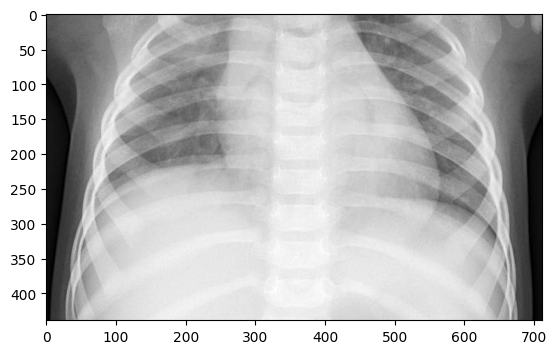

In [7]:
xray_image = cv2.imread(f'{train_path_pneu}/person1_bacteria_1.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(xray_image, cmap='gray')

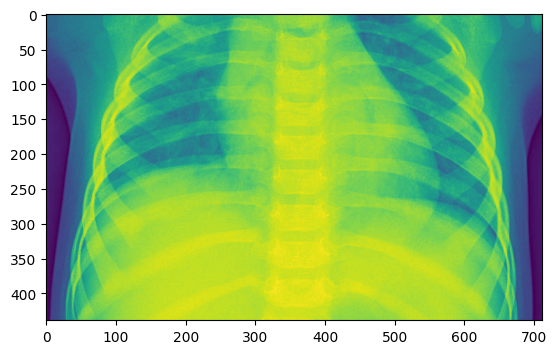

In [8]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
xray_image_scaled = transform_img(xray_image)
colored_xray = cm.viridis(xray_image_scaled)
plt.imshow(colored_xray)

#### Load and preprocess the images

In [9]:
img_size = (128, 128)

def load_images_from_folder(folder, label, target_size=img_size):
    """
    Loads images from a given folder and resizes them to the specified target size.
    Converts images to RGB and flattens them into numpy arrays.

    Args:
        folder (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of image data and their corresponding labels.
    """
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB").resize(target_size)
            data.append(np.array(img).flatten())
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return data, labels

def load_and_limit_data(path, label, num_samples, target_size=(256, 256)):
    """
    Loads and limits the number of images from a folder to a specified number of samples.
    Ensures images are resized to the specified target size.

    Args:
        path (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        num_samples (int): Maximum number of samples to load.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of limited image data and their corresponding labels.
    """
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = [data[i] for i in indices]
    labels = [labels[i] for i in indices]
    return data, labels

#### Display images for train

Found 5216 validated image filenames belonging to 2 classes.


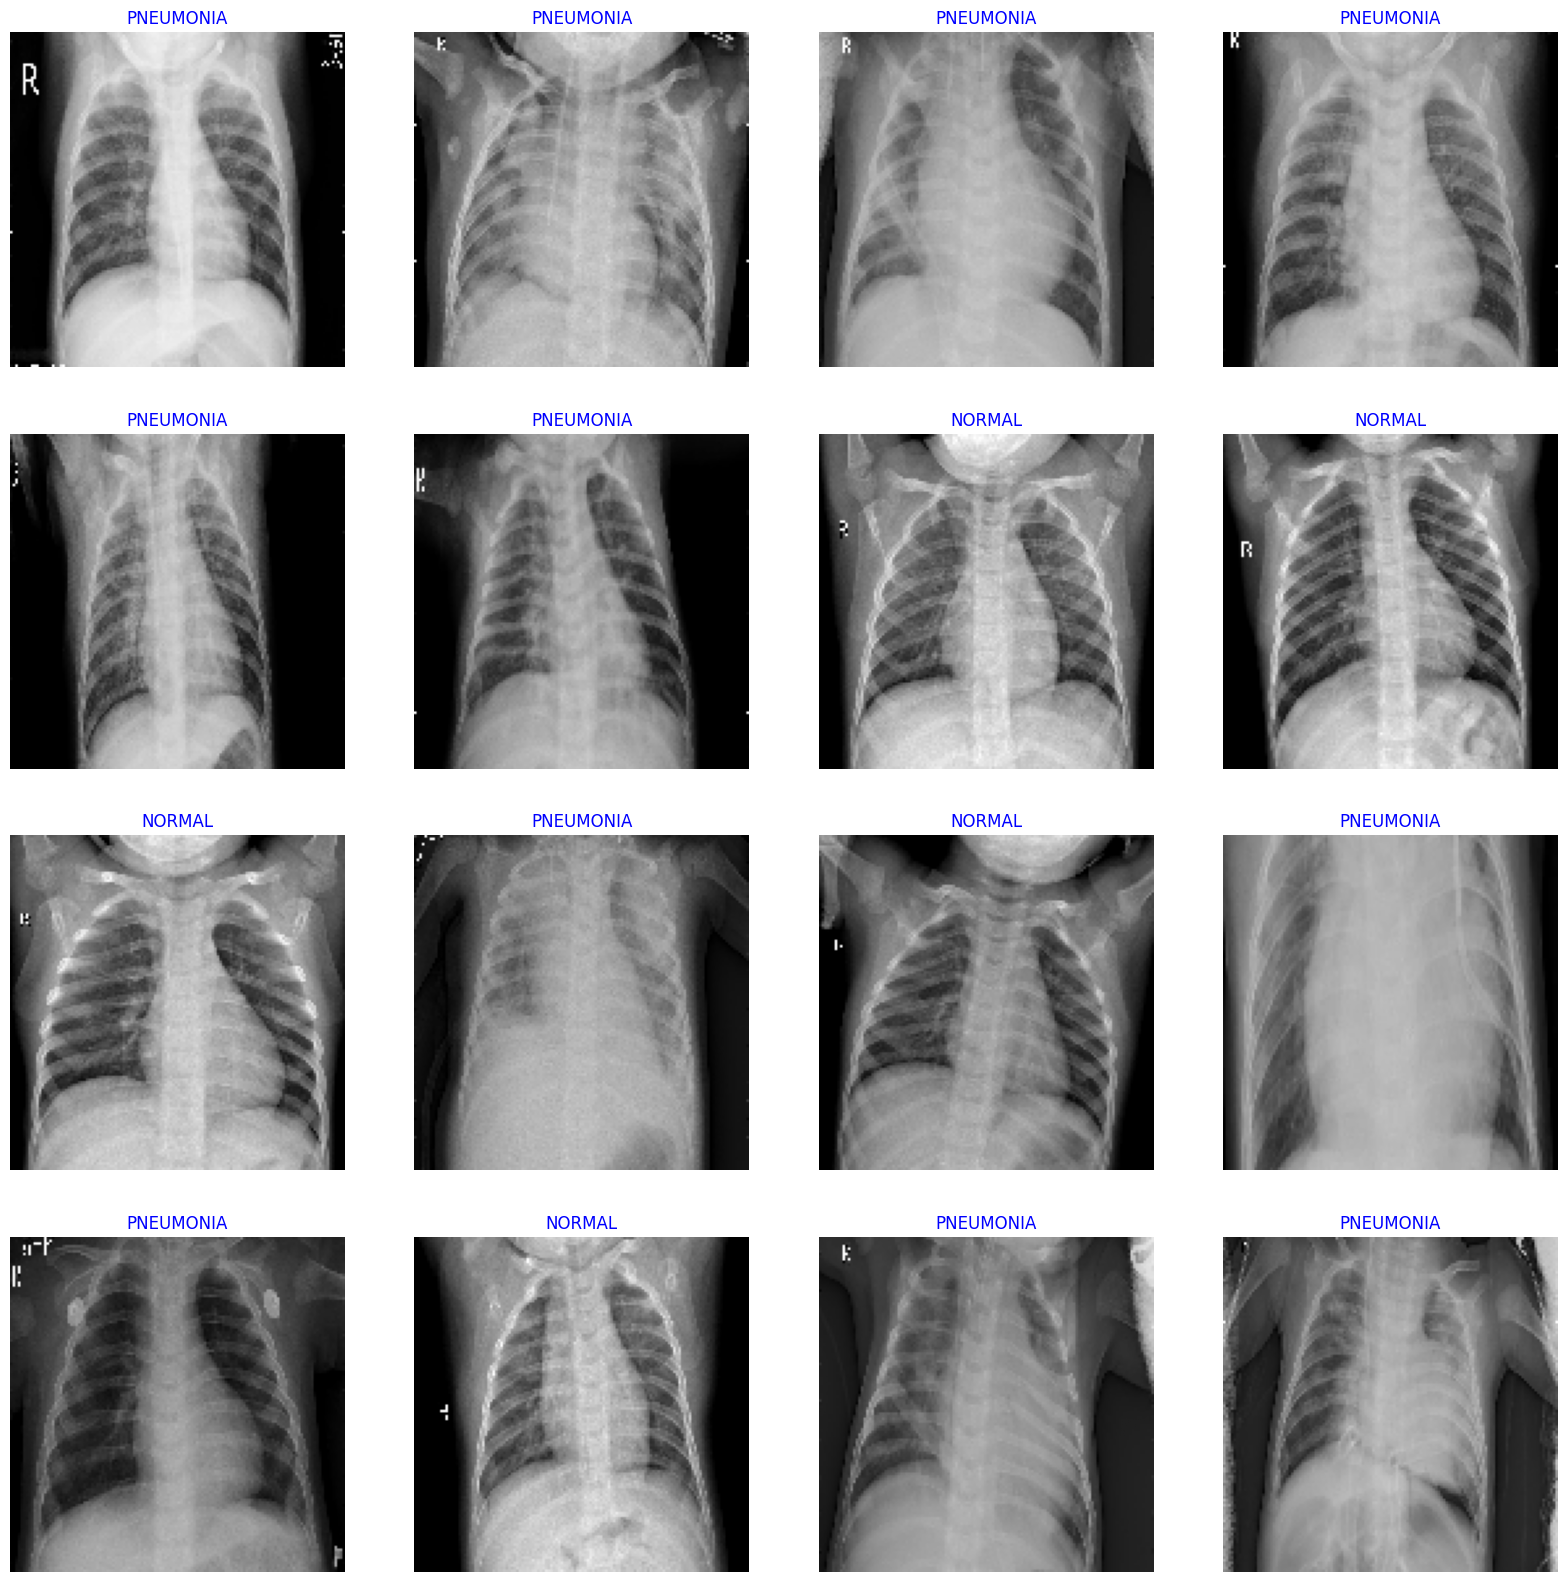

In [10]:
def create_dataframe_from_directory(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    labels = [label] * len(filepaths)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

df_norm = create_dataframe_from_directory(train_path_norm, 'NORMAL')
df_pneu = create_dataframe_from_directory(train_path_pneu, 'PNEUMONIA')

train_df = pd.concat([df_norm, df_pneu], ignore_index=True)

train_df = train_df.sample(frac=1).reset_index(drop=True)

def scalar(img):
    return img

batch_size = 32
tr_gen = ImageDataGenerator(preprocessing_function= scalar)


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= True,
    batch_size= batch_size
)

g_dict = train_gen.class_indices     
classes = list(g_dict.keys())       
images, labels = next(train_gen)      
plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255     
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

#### Proportional sampling for balanced dataset

In [11]:
num_samples = 250
num_samples_test = 50

norm_ratio = 1341 / (1341 + 3875)
pneu_ratio = 3875 / (1341 + 3875)

num_samples_norm = int(num_samples * norm_ratio)
num_samples_pneu = int(num_samples * pneu_ratio)

num_samples_norm_test = int(num_samples_test * norm_ratio)
num_samples_pneu_test = int(num_samples_test * pneu_ratio)

In [12]:
train_data_norm, train_labels_norm = load_and_limit_data(train_path_norm, 0, num_samples_norm, target_size=img_size)
train_data_pneu, train_labels_pneu = load_and_limit_data(train_path_pneu, 1, num_samples_pneu, target_size=img_size)
X_train = np.array(train_data_norm + train_data_pneu)
y_train = np.array(train_labels_norm + train_labels_pneu)

test_data_norm, test_labels_norm = load_and_limit_data(test_path_norm, 0, num_samples_norm_test, target_size=img_size)
test_data_pneu, test_labels_pneu = load_and_limit_data(test_path_pneu, 1, num_samples_pneu_test, target_size=img_size)
X_test = np.asarray(test_data_norm + test_data_pneu)
y_test = np.asarray(test_labels_norm + test_labels_pneu)

In [13]:
X_train_res = X_train.reshape(X_train.shape[0], -1)
X_test_res = X_test.reshape(X_test.shape[0], -1)

In [14]:
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train_res)

X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_train_numpy = X_train_tensor.detach().cpu().numpy()
y_train_numpy = y_train_tensor.detach().cpu().numpy()

In [15]:
X_test_pca = pca.transform(X_test_res)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

X_test_numpy = X_test_tensor.detach().cpu().numpy()
y_test_numpy = y_test_tensor.detach().cpu().numpy()

#### Create & Visualize the QNN

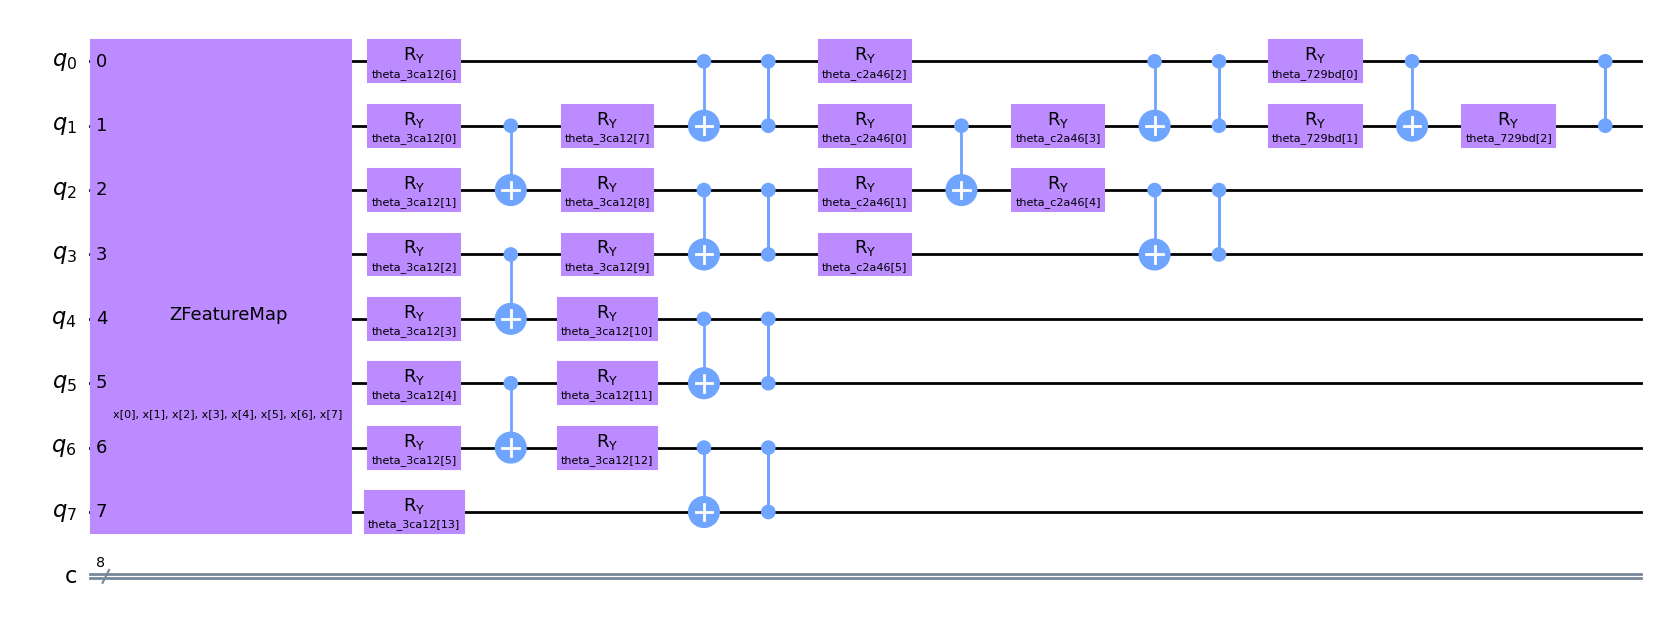

In [16]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

conv_layer1, _ = QuantumConvolutionalLayer(num_qubits=8).build_layer()
ansatz.compose(conv_layer1, list(range(8)), inplace=True)

pool_layer1, _ = QuantumPoolingLayer2(num_qubits=8, circuit=QuantumCircuit(8), unmeasured_bits=list(range(8))).build_layer()
ansatz.compose(pool_layer1, list(range(8)), inplace=True)

conv_layer2, _ = QuantumConvolutionalLayer(num_qubits=4).build_layer()
ansatz.compose(conv_layer2, list(range(4)), inplace=True)

pool_layer2, _ = QuantumPoolingLayer2(num_qubits=4, circuit=QuantumCircuit(4), unmeasured_bits=list(range(4))).build_layer()
ansatz.compose(pool_layer2, list(range(4)), inplace=True)

conv_layer3, _ = QuantumConvolutionalLayer(num_qubits=2).build_layer()
ansatz.compose(conv_layer3, list(range(2)), inplace=True)

pool_layer3, _ = QuantumPoolingLayer2(num_qubits=2, circuit=QuantumCircuit(2), unmeasured_bits=list(range(2))).build_layer()
ansatz.compose(pool_layer3, list(range(2)), inplace=True)

circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

circuit.draw("mpl", style="clifford")


#### Objective function visualization

In [17]:
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

#### Train with SPSA optimizer

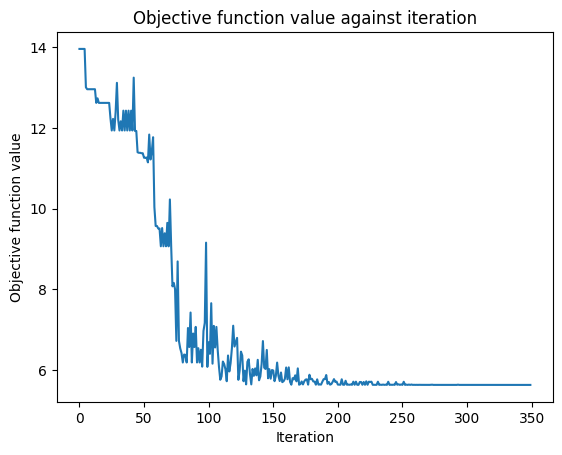

In [18]:
classifier = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=COBYLA(maxiter=500),
    loss='cross_entropy',
    callback=callback_graph
)

classifier.fit(X_train_numpy, y_train_numpy)

#### Save model

In [23]:
classifier.save('models/NeuralNetworkClassifier_piqture_brain_tumor.model')

#### Load model

In [20]:
loaded_model = classifier.load('models/NeuralNetworkClassifier_piqture_brain_tumor.model')

In [24]:
train_accuracy = np.round(100 * classifier.score(X_train_numpy, y_train_numpy), 2)
print(f"Accuracy from the training data: {train_accuracy}%")
print("***************************************************")
test_accuracy = np.round(100 * classifier.score(X_test_numpy, y_test_numpy), 2)
print(f"Accuracy from the test data: {test_accuracy}%")
predictions = classifier.predict(X_test_numpy)
print("***************************************************")
accuracy = np.mean(predictions == y_test_numpy)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy from the training data: 63.45%
***************************************************
Accuracy from the test data: 55.1%
***************************************************
Accuracy: 58.56%


In [25]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright